In [1]:
#from tensorflow.keras.models import load_model

import tensorflow as tf


In [2]:
# Charger le modèle
model = tf.keras.models.load_model('FNN model.h5')

C:\Users\topalian\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Importation des librairies
import pandas as pd
import numpy as np
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from brukeropusreader import read_file
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Real, Categorical, Integer
import warnings
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.initializers import RandomNormal, lecun_uniform
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adamax, Nadam
from tensorflow.keras.initializers import he_normal, glorot_uniform, lecun_uniform, RandomNormal
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from itertools import cycle
from itertools import product
from tensorflow.keras.layers import Dense, AlphaDropout
from sklearn.model_selection import KFold

warnings.filterwarnings('ignore')  # Ignore all warnings

In [17]:

# Chemins vers vos dossiers
folder_path_oe = 'OE tissue'
folder_path_re = 'RE tissue'
folder_path_trachea = 'Trachea tissue'

In [18]:
class GradientLogger(Callback):
    def __init__(self, model, validation_data):
        super(GradientLogger, self).__init__()
        self.model = model
        self.validation_data = validation_data
        self.grads = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        with tf.GradientTape() as tape:
            y_pred = self.model(x_val, training=True)
            loss = self.model.compiled_loss(y_val, y_pred)
        grads = tape.gradient(loss, self.model.trainable_weights)
        avg_grads = [tf.reduce_mean(tf.abs(grad)) for grad in grads]
        self.grads.append(avg_grads)
        print(f'End of epoch {epoch + 1}, average gradients: {avg_grads}')
        
        # Optionally, plot the gradients
        self.plot_gradients(epoch)

    def plot_gradients(self, epoch):
        plt.figure(figsize=(12, 8))
        for i, grad in enumerate(self.grads[-1]):
            plt.plot(i, grad, 'bo')
        plt.title(f'Gradient magnitudes at epoch {epoch + 1}')
        plt.xlabel('Layer')
        plt.ylabel('Average Gradient Magnitude')
        plt.show()

In [19]:
# Fonction pour lister les fichiers dans un dossier
def list_files(folder_path):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    return files

# Lister les fichiers dans chaque dossier
files_re = list_files(folder_path_re)
files_oe = list_files(folder_path_oe)
files_trachea = list_files(folder_path_trachea)

# Displaying file names and their count
print("RE Folder:")
print(f"Number of files: {len(files_re)}")
print("Files:", files_re)

print("\nOE Folder:")
print(f"Number of files: {len(files_oe)}")
print("Files:", files_oe)

print("\nTrachea Folder:")
print(f"Number of files: {len(files_trachea)}")
print("Files:", files_trachea)

RE Folder:
Number of files: 159
Files: ['19022024 RE 1.0000', '19022024 RE 1.0001', '19022024 RE 1.0002', '19022024 RE 1.0003', '19022024 RE 1.0004', '19022024 RE 2.0000', '19022024 RE 2.0001', '19022024 RE 2.0002', '19022024 RE 2.0003', '19022024 RE 2.0004', '19022024 RE 3 2.1', '19022024 RE 3 2.2', '19022024 RE 3 2.3', '19022024 RE 3 2.4', '19022024 RE 3.0000', '19022024 RE 3.0001', '19022024 RE 3.0002', '19022024 RE 3.0003', '19022024 RE 3.0004', '19022024 RE 4.0000', '19022024 RE 4.0001', '19022024 RE 4.0002', '19022024 RE 4.0003', '19022024 RE 4.0004', '19022024 RE 5.0000', '19022024 RE 5.0001', '19022024 RE 5.0002', '19022024 RE 5.0003', '19022024 RE 5.0004', '20240304 RE 1.0000', '20240304 RE 1.0001', '20240304 RE 1.0002', '20240304 RE 1.0003', '20240304 RE 1.0004', '20240304 RE 2.0000', '20240304 RE 2.0001', '20240304 RE 2.0002', '20240304 RE 2.0003', '20240304 RE 2.0004', '20240304 RE 3.0000', '20240304 RE 3.0001', '20240304 RE 3.0002', '20240304 RE 3.0003', '20240304 RE 3.000

In [20]:
# Définir l'ensemble commun de nombres d'onde
start_wavenumber = 5000  # Le nombre d'onde de départ
end_wavenumber = 400  # Le nombre d'onde de fin
resolution = 1  # La résolution en cm⁻¹

# Générer l'ensemble commun de nombres d'onde
common_wavenumbers = np.arange(start_wavenumber, end_wavenumber - resolution, -resolution)

# Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble pour s'assurer qu'il correspond à vos attentes
print("Premier nombre d'onde :", common_wavenumbers[0])
print("Dernier nombre d'onde :", common_wavenumbers[-1])
print("Nombre total de points :", len(common_wavenumbers))

Premier nombre d'onde : 5000
Dernier nombre d'onde : 400
Nombre total de points : 4601


In [21]:
def get_wavenumbers(file_path):
    opus_data = read_file(file_path)
    # Supposons que les nombres d'onde sont stockés dans une clé 'WN' dans les données retournées
    # Extraire le nombre de points, le nombre d'onde de début et de fin
    num_points = len(opus_data['AB'])
    start_wn = opus_data['AB Data Parameter']['FXV']
    end_wn = opus_data['AB Data Parameter']['LXV']
# Générer la liste des nombres d'onde
    wavenumbers = np.linspace(start_wn, end_wn, num_points)
    
    return wavenumbers

In [22]:
def get_spectral_data(file_path):
    """
    Extracts spectral data (e.g., absorbance values) from a file.

    Parameters:
    - file_path: The path to the Bruker file.

    Returns:
    - A numpy array containing the spectral data.
    """
    opus_data = read_file(file_path)
    # Assuming the spectral data is stored in the 'AB' key
    spectral_data = opus_data['AB']
    return spectral_data

# You may need to adjust the `read_file` function to return the entire opus_data dictionary.

In [23]:
def interpolate_to_common_wavenumbers(file_path, common_wavenumbers):
    """
    Interpolates the spectral data from a file to a common set of wavenumbers.
    
    Parameters:
    - file_path: The path to the file.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of the interpolated spectral data.
    """
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    interpolation_func = interp1d(original_wavenumbers, original_data, kind='linear', fill_value="extrapolate")
    interpolated_data = interpolation_func(common_wavenumbers)
    return interpolated_data

In [24]:
def z_score_normalize(data):
    """
    Normalizes a data array using Z-score normalization.
    
    Parameters:
    - data: A numpy array of spectral data.
    
    Returns:
    - The Z-score normalized spectral data.
    """
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

In [25]:
def process_directory(folder_path, common_wavenumbers):
    """
    Processes all files in a directory, interpolating and normalizing their spectral data.
    
    Parameters:
    - folder_path: The path to the directory.
    - common_wavenumbers: The common wavenumbers to interpolate the data to.
    
    Returns:
    - A numpy array of all the normalized spectral data from the directory.
    """
    normalized_data_list = []
    files = list_files(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)
        normalized_data = z_score_normalize(data)
        normalized_data_list.append(normalized_data)
    return np.array(normalized_data_list)

In [26]:
# Process directories
data_oe = process_directory('OE tissue', common_wavenumbers)
data_re = process_directory('RE tissue', common_wavenumbers)
data_trachea = process_directory('Trachea tissue', common_wavenumbers)

In [27]:
print(data_trachea)

[[-0.61579656 -0.58273383 -0.59939523 ...  0.3620638   0.49074305
  -0.1792348 ]
 [-0.72047611 -0.52062885 -0.46240616 ...  0.22521603  0.14860448
  -0.29150757]
 [-0.69120412 -0.527085   -0.60325053 ... -0.05718319  0.21270616
  -0.24826464]
 ...
 [-0.67619257 -0.77097338 -0.72257393 ...  0.37798956  0.3983332
  -0.21651638]
 [-0.5691582  -0.60711652 -0.81834779 ...  0.40124616  0.72118649
  -0.04438686]
 [-0.57783496 -0.86311322 -0.85548432 ...  0.26851423  0.29636962
  -0.1816398 ]]


In [28]:
# Vérifier si la liste des fichiers n'est pas vide
if files_trachea:
    first_file_trachea = files_trachea[0]
    print("Le premier fichier dans le dossier 'Trachea tissue' est:", first_file_trachea)
else:
    print("Aucun fichier trouvé dans le dossier.")

Le premier fichier dans le dossier 'Trachea tissue' est: 19022024 TE 1.0000


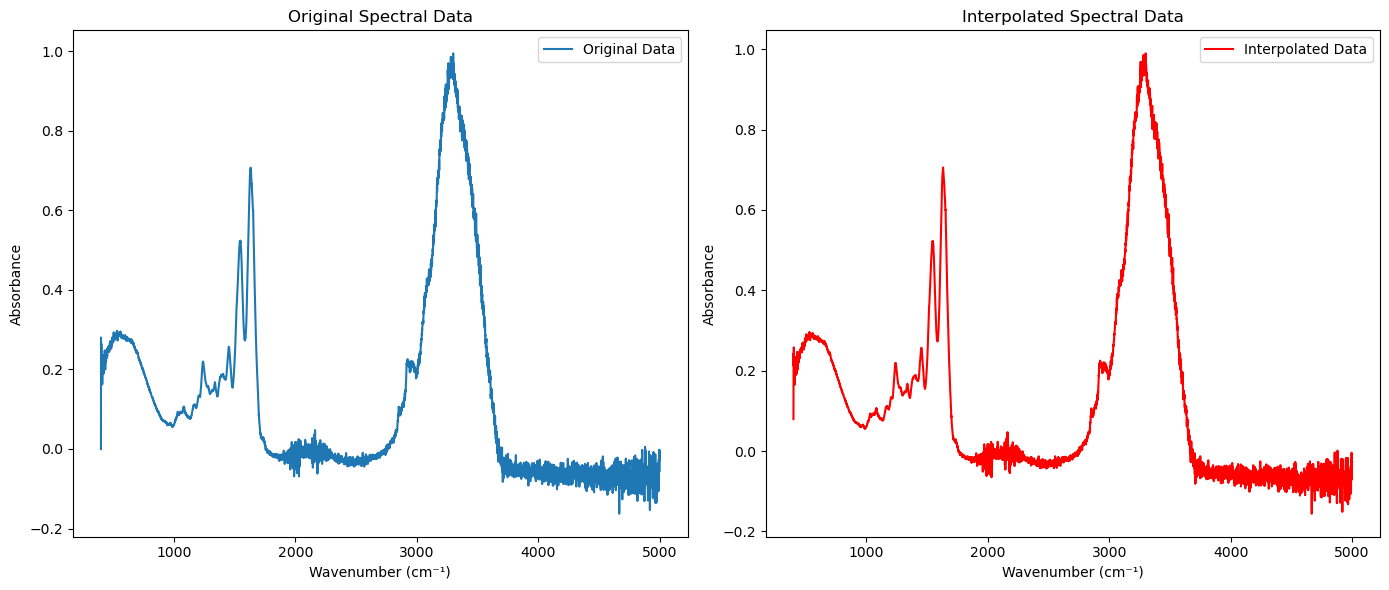

In [29]:
def plot_original_vs_interpolated(file_path, common_wavenumbers):
    # Obtenir les données spectrales et les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    original_data = get_spectral_data(file_path)
    
    # Interpolation des données aux nombres d'onde communs
    interpolated_data = interpolate_to_common_wavenumbers(file_path, common_wavenumbers)

    # Tracer les données originales
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1ère subplot
    plt.plot(original_wavenumbers, original_data, label='Original Data')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Original Spectral Data')
    plt.legend()

    # Tracer les données interpolées
    plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème subplot
    plt.plot(common_wavenumbers, interpolated_data, label='Interpolated Data', color='red')
    plt.xlabel('Wavenumber (cm⁻¹)')
    plt.ylabel('Absorbance')
    plt.title('Interpolated Spectral Data')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Exemple d'utilisation sur un fichier spécifique
# Chemin complet du premier fichier
first_file_path = os.path.join(folder_path_trachea, first_file_trachea)

# Utilisation du fichier pour tracer les données originales et interpolées
plot_original_vs_interpolated(first_file_path, common_wavenumbers)

In [30]:
def print_wavenumber_range(file_path, common_wavenumbers):
    # Extraire les nombres d'onde originaux
    original_wavenumbers = get_wavenumbers(file_path)
    
    # Afficher la plage des nombres d'onde originaux
    print("Plage des nombres d'onde originaux:")
    print(" - Min:", np.min(original_wavenumbers))
    print(" - Max:", np.max(original_wavenumbers))
    
    # Afficher la plage des nombres d'onde interpolés
    print("Plage des nombres d'onde interpolés:")
    print(" - Min:", np.min(common_wavenumbers))
    print(" - Max:", np.max(common_wavenumbers))

# Utilisation du premier fichier du dossier "Trachea tissue"
folder_path_trachea = 'Trachea tissue'
files_trachea = list_files(folder_path_trachea)

if files_trachea:
    first_file_trachea = files_trachea[0]
    first_file_path = os.path.join(folder_path_trachea, first_file_trachea)
    print_wavenumber_range(first_file_path, common_wavenumbers)
else:
    print("Aucun fichier trouvé dans le dossier.")

Plage des nombres d'onde originaux:
 - Min: 399.89875569939613
 - Max: 4999.6262811124325
Plage des nombres d'onde interpolés:
 - Min: 400
 - Max: 5000


In [31]:
# Fonction pour filtrer les nombres d'onde dans deux plages spécifiques et les concaténer
def filter_and_concatenate_wavenumbers(data, wavenumbers, ranges):
    filtered_data_list = []
    filtered_wavenumbers_list = []
    
    for min_w, max_w in ranges:
        indices = np.where((wavenumbers >= min_w) & (wavenumbers <= max_w))[0]
        if len(indices) == 0:
            print(f"Aucun indice trouvé pour la plage {min_w}-{max_w}")
            continue
        print(f"Indices trouvés pour la plage {min_w}-{max_w}: {indices}")
        filtered_data_list.append(data[:, indices])
        filtered_wavenumbers_list.append(wavenumbers[indices])
    
    if not filtered_data_list:
        raise ValueError("Aucun indice valide trouvé dans les plages spécifiées.")
    
    concatenated_data = np.concatenate(filtered_data_list, axis=1)
    concatenated_wavenumbers = np.concatenate(filtered_wavenumbers_list)
    
    return concatenated_data, concatenated_wavenumbers

# Définir les plages de filtres
ranges = [(900, 1800)]
#ranges = [(2800, 3000), (900, 1800)]
#ranges = [(400, 5000)]

In [32]:
# Vérification des limites
print(f"common_wavenumbers: min={common_wavenumbers.min()}, max={common_wavenumbers.max()}")

# Filtrer et concaténer les données de chaque tissu
try:
    data_oe, common_wavenumbers = filter_and_concatenate_wavenumbers(data_oe, common_wavenumbers, ranges)
    data_re, common_wavenumbers = filter_and_concatenate_wavenumbers(data_re, common_wavenumbers, ranges)
    data_trachea, common_wavenumbers = filter_and_concatenate_wavenumbers(data_trachea, common_wavenumbers, ranges)

    # Vérifiez la première et dernière valeurs ainsi que la taille de l'ensemble filtré pour s'assurer qu'il correspond à vos attentes
    print("Premier nombre d'onde filtré :", common_wavenumbers[0])
    print("Dernier nombre d'onde filtré :", common_wavenumbers[-1])
    print("Nombre total de points filtrés :", len(common_wavenumbers))
except IndexError as e:
    print(f"Erreur d'indexation: {e}")
except ValueError as e:
    print(f"Erreur de valeur: {e}")

common_wavenumbers: min=400, max=5000
Indices trouvés pour la plage 900-1800: [3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227
 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241
 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255
 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269
 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281 3282 3283
 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297
 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311
 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325
 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339
 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353
 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367
 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381

In [33]:
# Assuming data_oe, data_re, data_trachea have already been calculated as shown in previous messages
# Combine the average spectral data into one dataset and create labels
X = np.vstack([data_oe, data_re, data_trachea])
y = np.array([0] * len(data_oe) + [1] * len(data_re) + [2] * len(data_trachea))

In [34]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]


In [35]:
# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [36]:
# Split data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 333
Validation set size: 111
Test set size: 111


In [37]:
# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [38]:
# Calculate class weights to handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y_temp)
class_weights = dict(enumerate(class_weights))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


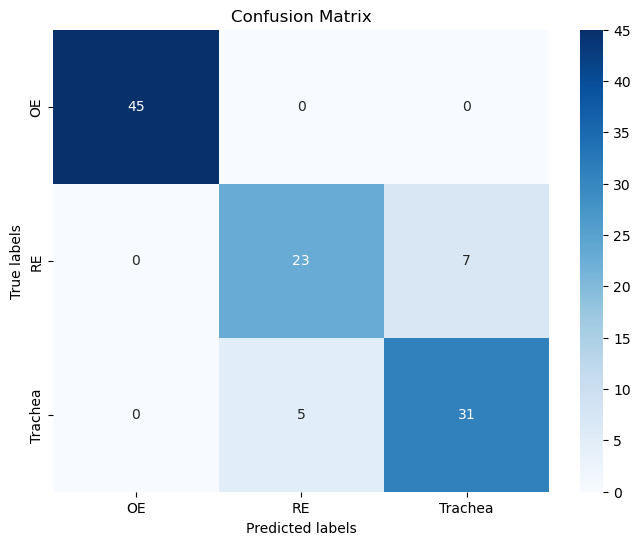

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prédire les classes sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['OE', 'RE', 'Trachea'], 
            yticklabels=['OE', 'RE', 'Trachea'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [41]:
# Générer un rapport de classification
print(classification_report(y_true, y_pred_classes, target_names=['OE', 'RE', 'Trachea']))


              precision    recall  f1-score   support

          OE       1.00      1.00      1.00        45
          RE       0.82      0.77      0.79        30
     Trachea       0.82      0.86      0.84        36

    accuracy                           0.89       111
   macro avg       0.88      0.88      0.88       111
weighted avg       0.89      0.89      0.89       111



In [42]:
wavenumber_range = np.linspace(900, 1800, 901)
feature_names = [f"{int(wavenumber)}" for wavenumber in wavenumber_range]


In [43]:
# Prédire les étiquettes de classe pour l'ensemble de test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_classes = np.argmax(y_test, axis=1)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [44]:
print(y_test_classes)

[1 2 0 2 0 2 2 0 1 1 0 0 1 1 2 0 1 0 0 1 2 2 0 0 1 0 2 2 0 2 1 1 1 0 2 0 0
 2 1 0 2 1 2 0 0 1 1 0 2 2 2 2 2 1 1 1 2 2 2 1 1 0 2 0 1 2 0 2 0 1 0 0 0 0
 2 1 1 2 0 0 0 1 2 0 2 2 0 0 0 0 0 1 1 0 0 0 1 0 2 0 1 2 0 2 2 0 0 1 0 2 2]


In [45]:
print(y_pred)

[2 1 0 2 0 2 2 0 1 1 0 0 1 1 2 0 1 0 0 1 2 2 0 0 1 0 2 1 0 2 1 1 1 0 1 0 0
 2 1 0 2 1 2 0 0 1 1 0 2 2 2 2 2 1 1 1 2 1 2 2 2 0 2 0 1 2 0 2 0 1 0 0 0 0
 2 1 2 2 0 0 0 2 2 0 2 2 0 0 0 0 0 2 1 0 0 0 2 0 2 0 1 1 0 2 2 0 0 1 0 2 2]


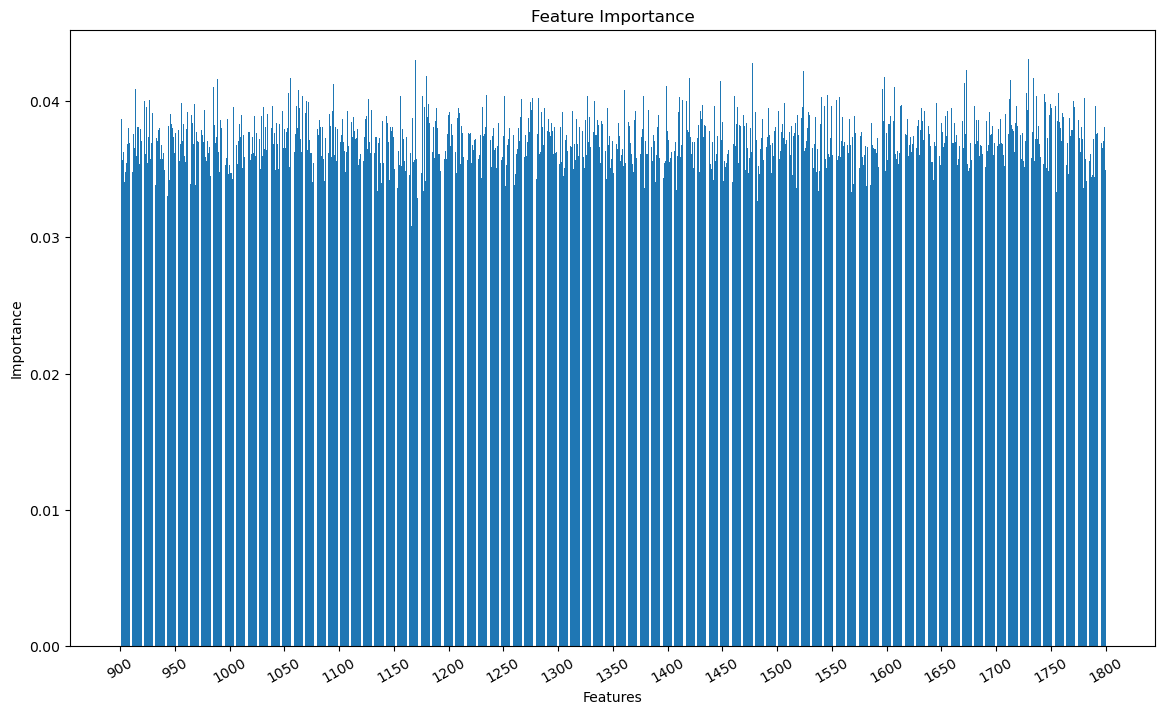

In [47]:
import matplotlib.pyplot as plt

# Extraire les poids de la première couche dense (supposant que la première couche est dense)
weights = model.layers[0].get_weights()[0]

# Calculer l'importance moyenne des caractéristiques
importances = np.mean(np.abs(weights), axis=1)
# Afficher les importances des caractéristiques
plt.figure(figsize=(14, 8))
plt.bar(range(len(feature_names)), importances)

# Afficher seulement chaque 50ème label pour améliorer la lisibilité
plt.xticks(range(0, len(feature_names), 50), feature_names[::50], rotation=30)

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

In [48]:
print(weights)
print(weights.shape)

[[ 1.46157155e-02 -3.33362743e-02  6.99564517e-02 ... -8.17288179e-03
   4.37861085e-02 -3.88770215e-02]
 [ 6.27829060e-02  5.75927123e-02 -4.94961329e-02 ... -1.24883316e-02
  -9.21778008e-03  5.95200481e-03]
 [-6.09542039e-05 -6.40840828e-02 -6.68559074e-02 ...  3.47604416e-02
  -5.88028878e-02 -6.84949383e-02]
 ...
 [-4.73269597e-02 -5.51691204e-02  7.79116387e-03 ...  6.78430572e-02
   1.27746277e-02  1.57670286e-02]
 [ 3.50375623e-02  3.52906510e-02  3.23525444e-02 ... -6.58928091e-03
   5.33929616e-02 -6.27292842e-02]
 [ 1.30453203e-02  3.72289605e-02 -1.45814121e-02 ... -5.63194081e-02
  -1.12349875e-02 -1.04545355e-02]]
(901, 150)


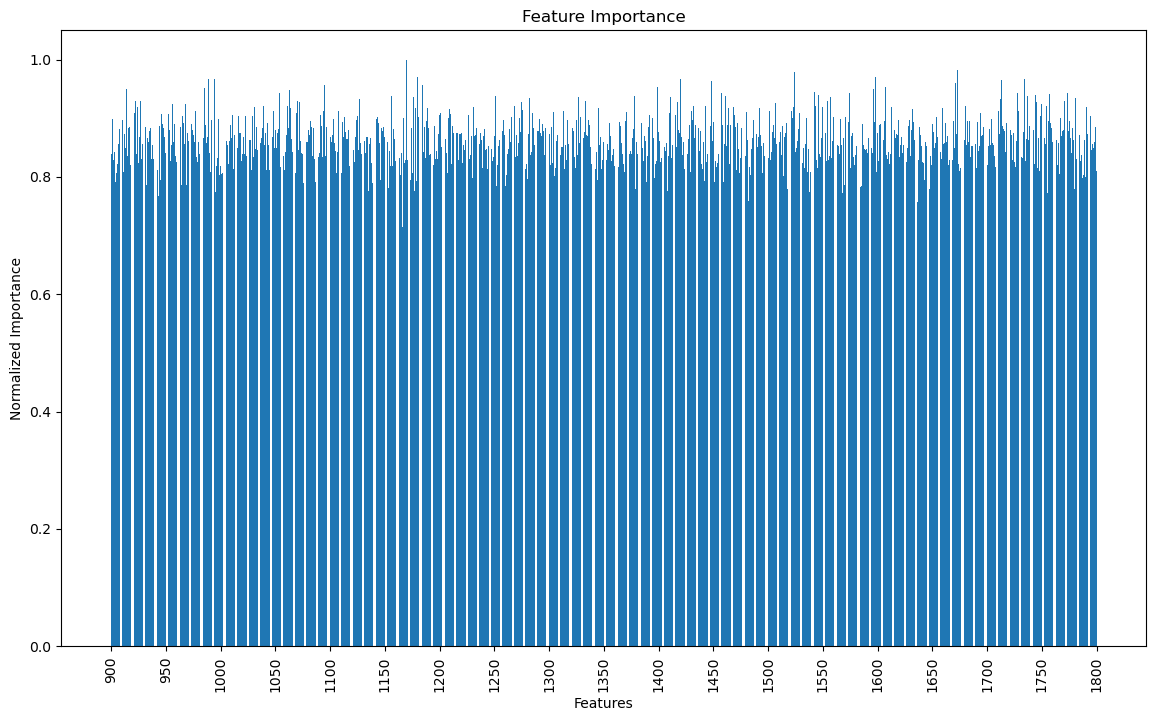

Mean Importance: 0.863383
Standard Deviation of Importance: 0.040905483


In [49]:
# Extraire les poids de la première couche dense (supposant que la première couche est dense)
weights = model.layers[0].get_weights()[0]

# Calculer l'importance moyenne des caractéristiques
importances = np.mean(np.abs(weights), axis=1)

# Normaliser les importances pour une meilleure comparaison
importances_normalized = importances / np.max(importances)

# Définir les noms des caractéristiques
wavenumber_range = np.linspace(900, 1800, 901)
feature_names = [f"{int(wavenumber)}" for wavenumber in wavenumber_range]

# Afficher les importances des caractéristiques
plt.figure(figsize=(14, 8))
plt.bar(range(len(feature_names)), importances_normalized)

# Afficher seulement chaque 50ème label pour améliorer la lisibilité
plt.xticks(range(0, len(feature_names), 50), feature_names[::50], rotation=90)

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance')
plt.show()

# Vérifier les valeurs d'importances pour confirmer s'ils sont équivalents
print("Mean Importance:", np.mean(importances_normalized))
print("Standard Deviation of Importance:", np.std(importances_normalized))

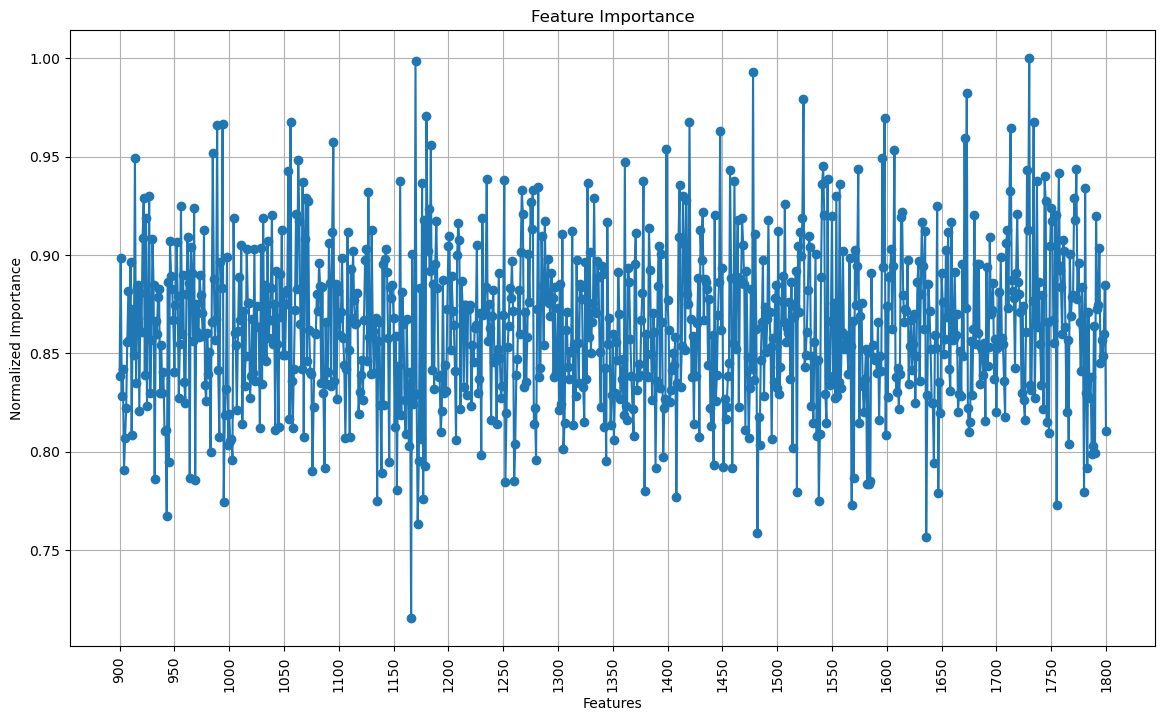

In [50]:
# Définir les noms des caractéristiques
wavenumber_range = np.linspace(900, 1800, 901)
feature_names = [f"{int(wavenumber)}" for wavenumber in wavenumber_range]

# Calculer l'importance moyenne des caractéristiques
importances = np.mean(np.abs(weights), axis=1)

# Normaliser les importances pour une meilleure comparaison
importances_normalized = importances / np.max(importances)

# Afficher les importances des caractéristiques
plt.figure(figsize=(14, 8))
plt.plot(range(len(feature_names)), importances_normalized, marker='o', linestyle='-')

# Afficher seulement chaque 50ème label pour améliorer la lisibilité
plt.xticks(range(0, len(feature_names), 50), feature_names[::50], rotation=90)

plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance')
plt.grid(True)
plt.show()

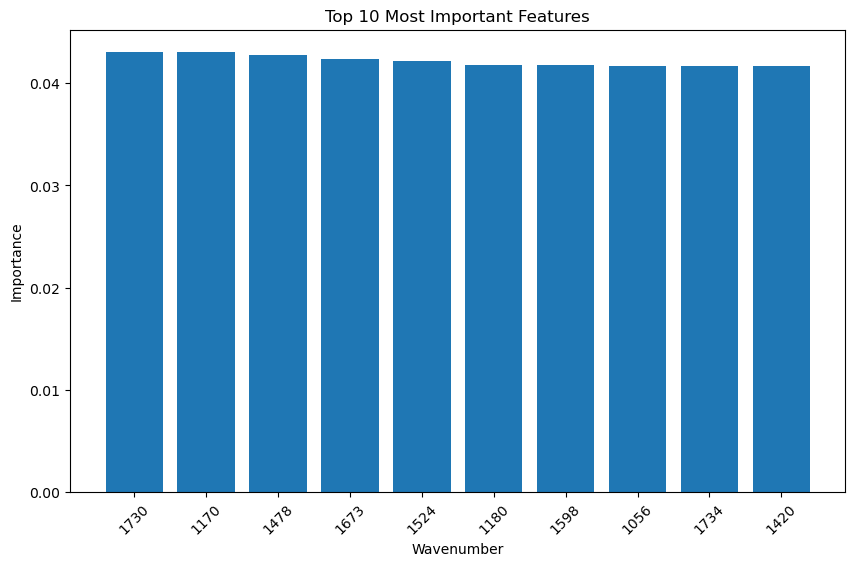

Feature: 1730, Importance: 0.0430980920791626
Feature: 1170, Importance: 0.04303968325257301
Feature: 1478, Importance: 0.042791061103343964
Feature: 1673, Importance: 0.04233730211853981
Feature: 1524, Importance: 0.04219762235879898
Feature: 1180, Importance: 0.04184110090136528
Feature: 1598, Importance: 0.04178933799266815
Feature: 1056, Importance: 0.04169950261712074
Feature: 1734, Importance: 0.041699159890413284
Feature: 1420, Importance: 0.041693393141031265


In [51]:
# Calculer l'importance moyenne des caractéristiques
importances = np.mean(np.abs(weights), axis=1)

# Définir les noms des caractéristiques
wavenumber_range = np.linspace(900, 1800, 901)
feature_names = [f"{int(wavenumber)}" for wavenumber in wavenumber_range]

# Trouver les indices des 10 caractéristiques les plus importantes
top_indices = np.argsort(importances)[-10:]

# Trier les indices dans l'ordre décroissant pour l'affichage
top_indices = top_indices[np.argsort(importances[top_indices])[::-1]]

# Extraire les importances et les noms des caractéristiques correspondantes
top_importances = importances[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Afficher les 10 caractéristiques les plus importantes
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_importances)
plt.xlabel('Wavenumber')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features')
plt.xticks(rotation=45)
plt.show()

# Afficher les caractéristiques les plus importantes et leurs importances
for i in range(len(top_feature_names)):
    print(f"Feature: {top_feature_names[i]}, Importance: {top_importances[i]}")

In [52]:
import shap


In [53]:
# Define the number of samples to use
K = 100  # You can adjust this number based on your dataset size

# Summarize the background data using shap.sample
background = shap.sample(X_train, K)

In [55]:

# Créer un explainer SHAP pour le modèle
explainer = shap.KernelExplainer(model.predict, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [56]:
# Calculer les valeurs SHAP pour les données de test
shap_values = explainer(X_test)

  0%|          | 0/111 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12032/12032 ━━━━━━━━━━━━━━━━━━━━ 23s 2

In [57]:
type(shap_values)


shap._explanation.Explanation

In [58]:
print(shap_values)

.values =
array([[[ 0.00828907,  0.        , -0.00928178],
        [ 0.        , -0.01077403,  0.00753496],
        [-0.00353078, -0.01038244,  0.01701924],
        ...,
        [-0.01112859,  0.        ,  0.00045114],
        [ 0.        , -0.0014877 ,  0.        ],
        [ 0.        , -0.00616601,  0.00756754]],

       [[ 0.        ,  0.00602923, -0.01239126],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        , -0.00494616,  0.00986009],
        ...,
        [ 0.00318168,  0.        , -0.0084976 ],
        [ 0.0025856 ,  0.        ,  0.        ],
        [-0.00685862,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.00032942,  0.        ],
        [ 0.        , -0.00478528,  0.0109576 ],
        ...,
        [ 0.01660411,  0.        , -0.00937106],
        [-0.0002377 ,  0.        ,  0.00525372],
        [ 0.        , -0.00813045,  0.01114676]],

       ...,

       [[ 0.        , -0.00769223,  0.        ],
 

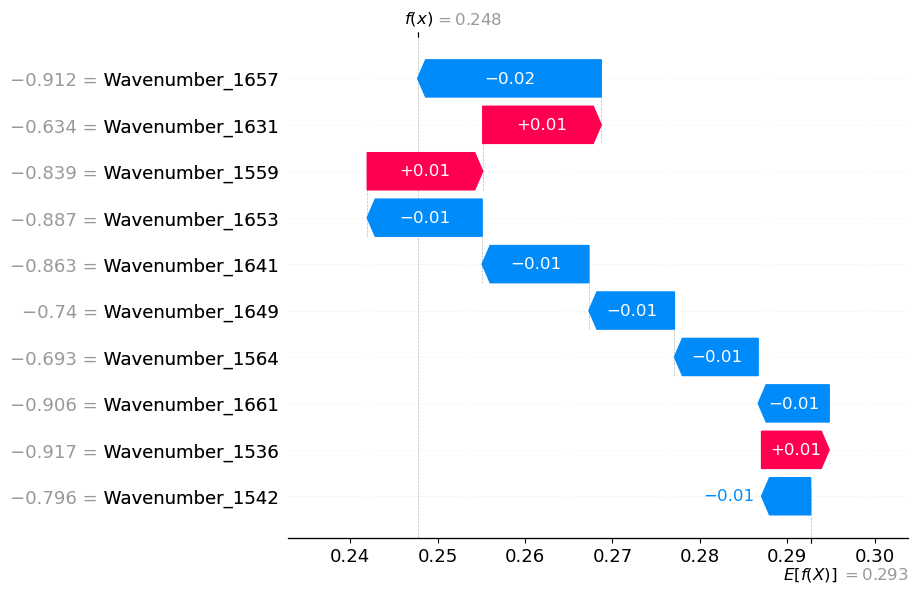

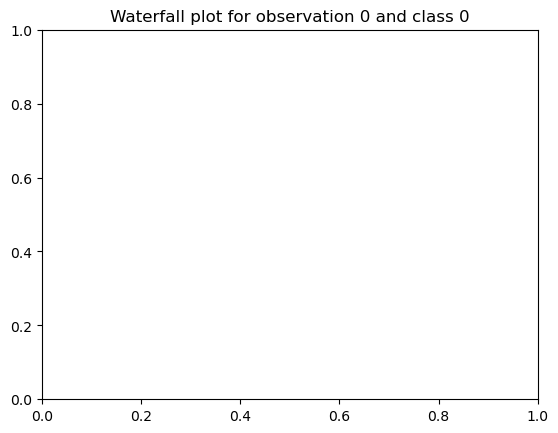

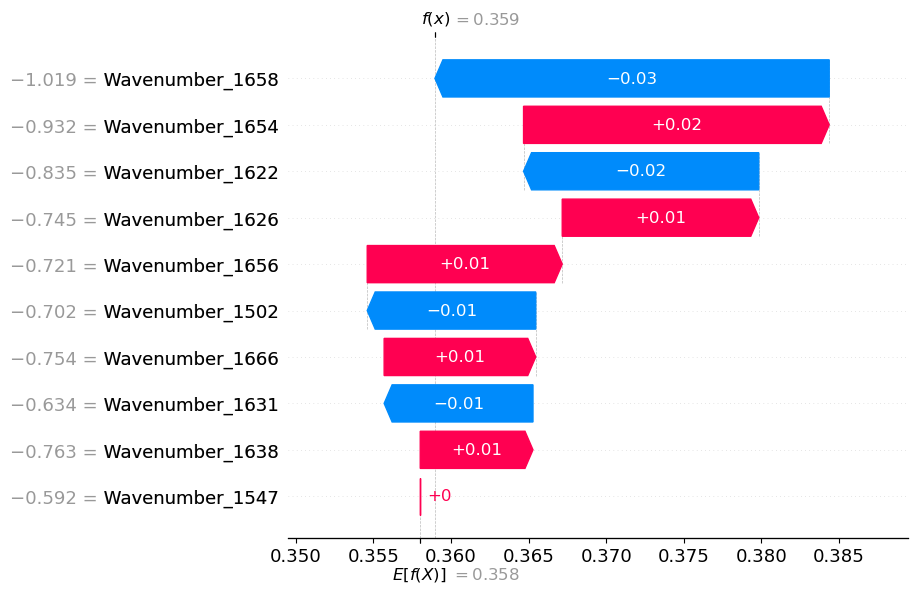

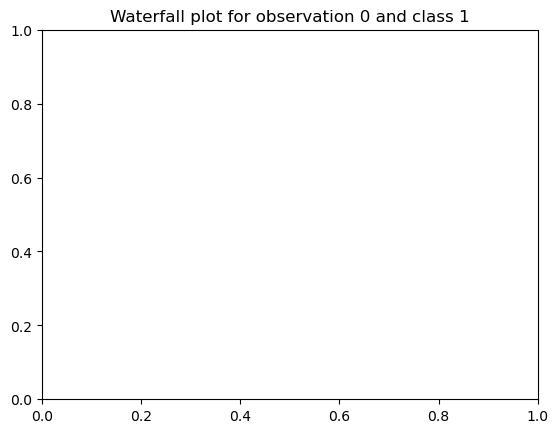

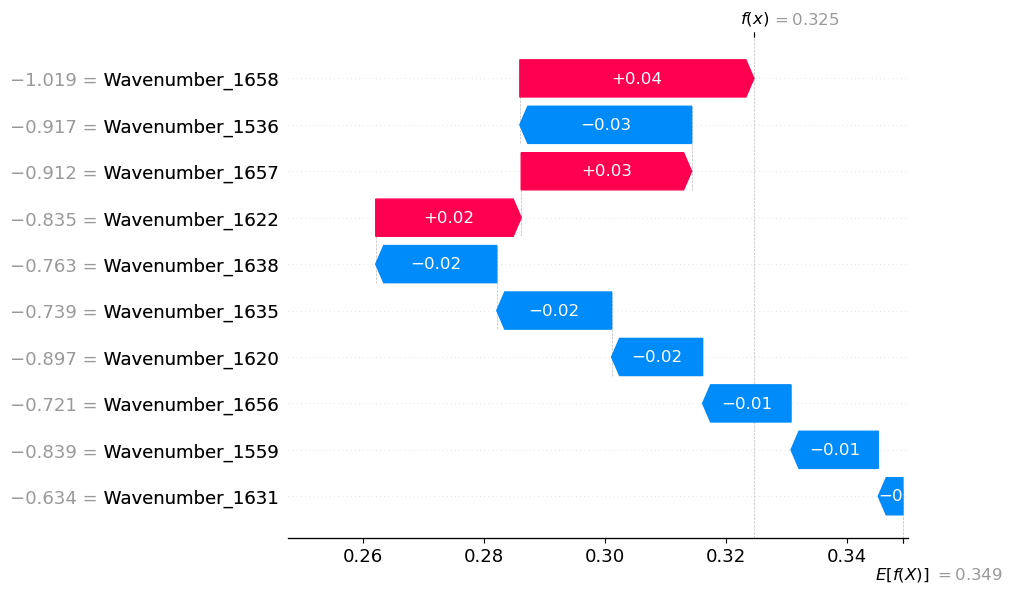

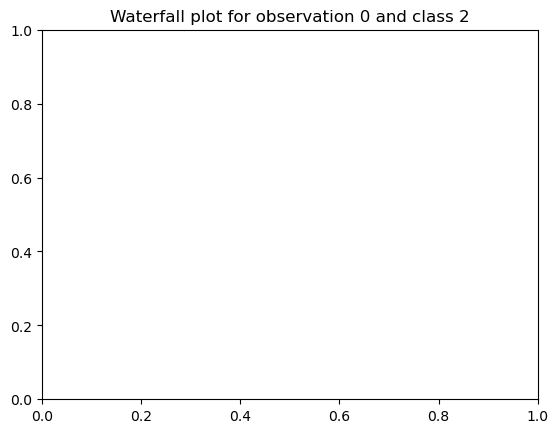

In [60]:
# Function to generate waterfall plot for a specific observation with top 10 features
def waterfall_plot_for_observation(shap_values, observation_index, class_index, top_10_indices, common_wavenumbers):
    shap_values_class = shap_values.values[..., class_index]

    # Create SHAP explanation for top 10 features
    shap_explanation = shap.Explanation(
        values=shap_values_class[observation_index, top_10_indices],
        base_values=shap_values.base_values[observation_index, class_index],
        data=shap_values.data[observation_index, top_10_indices],
        feature_names=[f'Wavenumber_{int(common_wavenumbers[i])}' for i in top_10_indices]
    )

    # Display waterfall plot
    shap.plots.waterfall(shap_explanation)
    plt.title(f'Waterfall plot for observation {observation_index} and class {class_index}')
    plt.show()

# Display waterfall plot for each class
observation_index = 0  # You can change this to visualize different observations
for class_index in range(num_classes):
    top_10_indices = top_10_indices_list[class_index]
    waterfall_plot_for_observation(shap_values, observation_index, class_index, top_10_indices, common_wavenumbers)

In [62]:
class_names = ['OE', 'RE', 'Trachea']


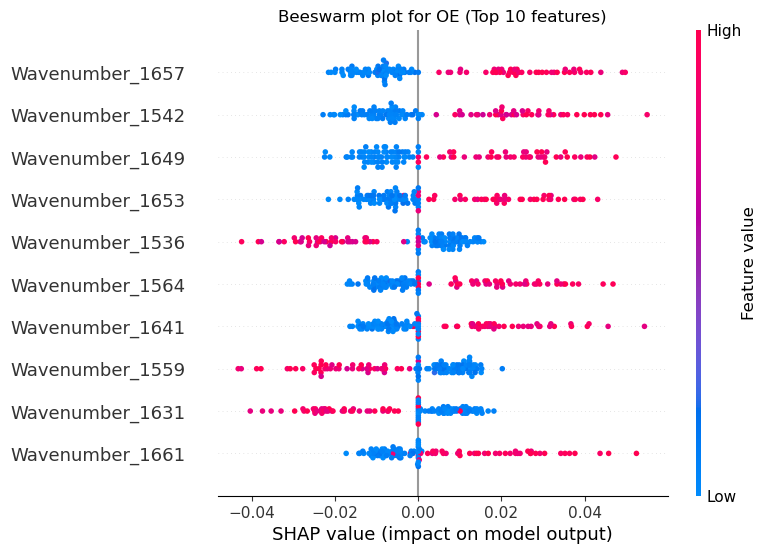

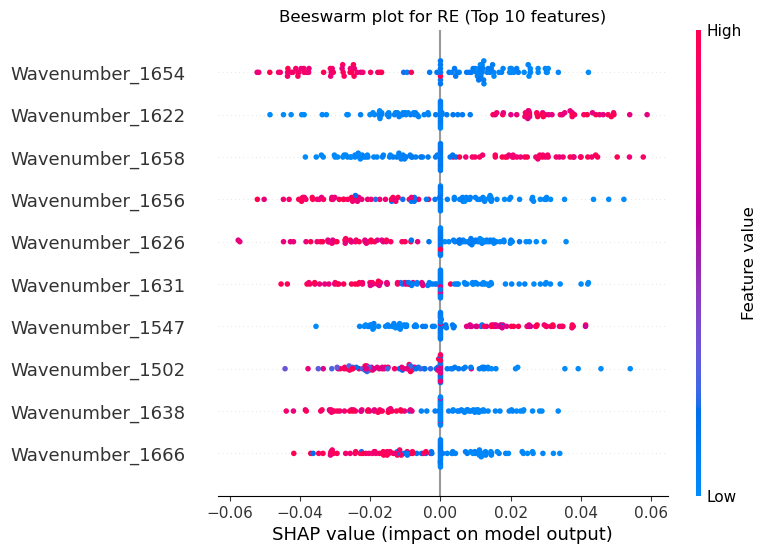

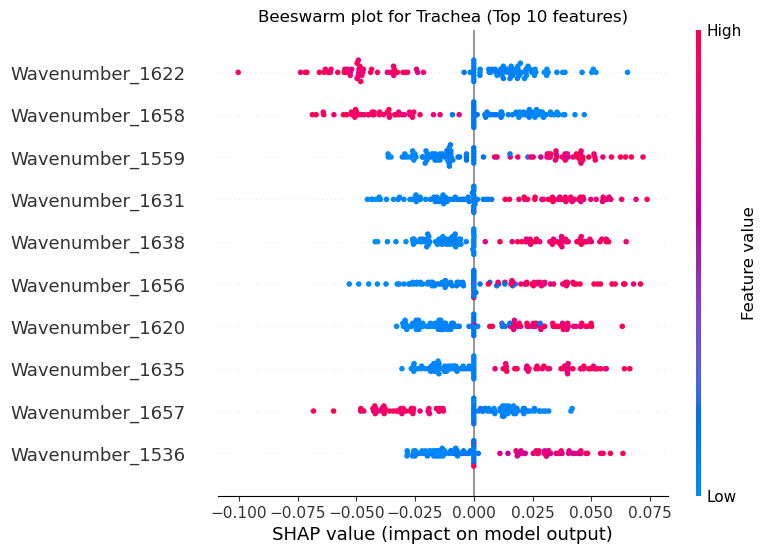

In [63]:
# Function to generate beeswarm plot for a specific class with top 10 features
def beeswarm_plot_top_10(shap_values, class_index, common_wavenumbers, class_names):
    shap_values_class = shap_values.values[..., class_index]
    mean_abs_shap = np.mean(np.abs(shap_values_class), axis=0)
    top_10_indices = np.argsort(mean_abs_shap)[-10:]

    # Create a reduced SHAP explanation for top 10 features
    shap_explanation_top_10 = shap.Explanation(
        values=shap_values_class[:, top_10_indices],
        base_values=shap_values.base_values[:, class_index],
        data=shap_values.data[:, top_10_indices],
        feature_names=[f'Wavenumber_{int(common_wavenumbers[i])}' for i in top_10_indices]
    )

    # Plot summary plot
    shap.summary_plot(shap_explanation_top_10, show=False)
    plt.title(f'Beeswarm plot for {class_names[class_index]} (Top 10 features)')
    plt.show()
    return top_10_indices

# Generate beeswarm plots for each class
num_classes = shap_values.values.shape[2]
top_10_indices_list = []
for class_index in range(num_classes):
    top_10_indices = beeswarm_plot_top_10(shap_values, class_index, common_wavenumbers, class_names)
    top_10_indices_list.append(top_10_indices)

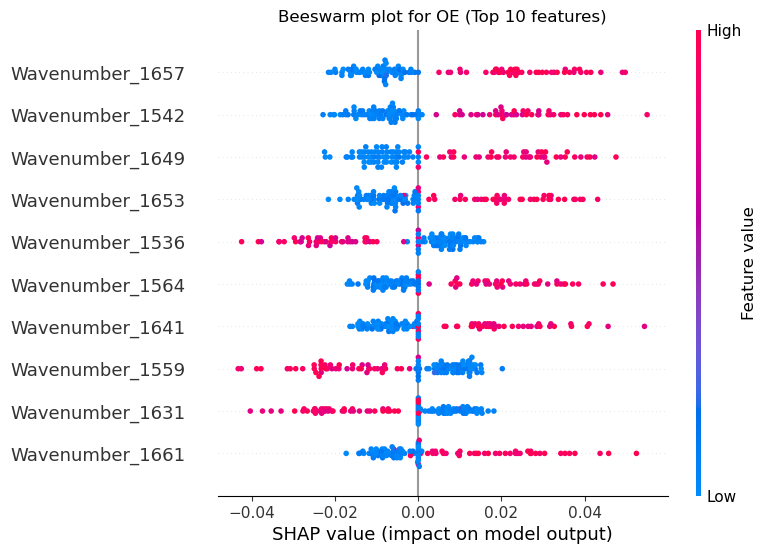

Top 10 wavenumbers for OE: [1661, 1631, 1559, 1641, 1564, 1536, 1653, 1649, 1542, 1657]


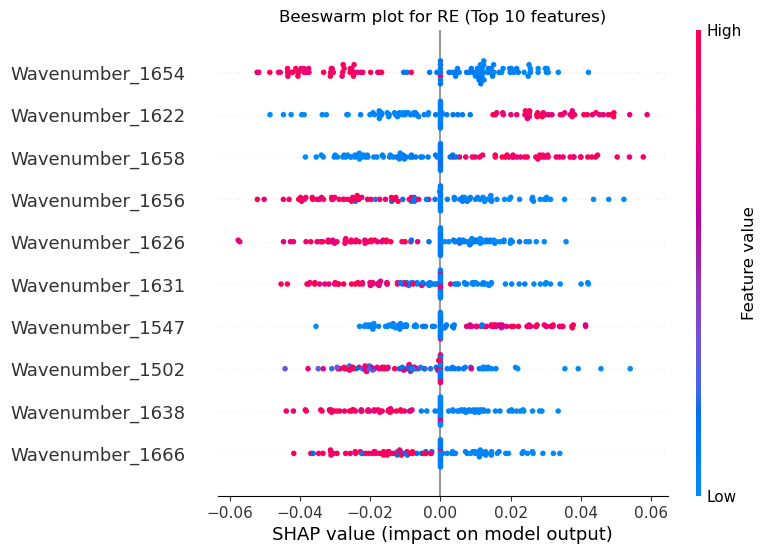

Top 10 wavenumbers for RE: [1666, 1638, 1502, 1547, 1631, 1626, 1656, 1658, 1622, 1654]


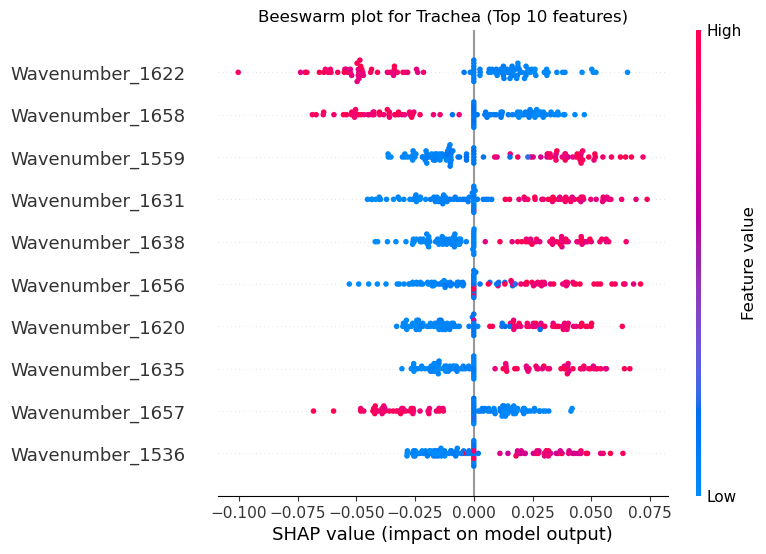

Top 10 wavenumbers for Trachea: [1536, 1657, 1635, 1620, 1656, 1638, 1631, 1559, 1658, 1622]
Top 10 wavenumbers for class OE: [1661, 1631, 1559, 1641, 1564, 1536, 1653, 1649, 1542, 1657]
Top 10 wavenumbers for class RE: [1666, 1638, 1502, 1547, 1631, 1626, 1656, 1658, 1622, 1654]
Top 10 wavenumbers for class Trachea: [1536, 1657, 1635, 1620, 1656, 1638, 1631, 1559, 1658, 1622]


In [64]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Function to generate beeswarm plot for a specific class with top 10 features
def beeswarm_plot_top_10(shap_values, class_index, common_wavenumbers, class_names):
    shap_values_class = shap_values.values[..., class_index]
    mean_abs_shap = np.mean(np.abs(shap_values_class), axis=0)
    top_10_indices = np.argsort(mean_abs_shap)[-10:]

    # Create a reduced SHAP explanation for top 10 features
    shap_explanation_top_10 = shap.Explanation(
        values=shap_values_class[:, top_10_indices],
        base_values=shap_values.base_values[:, class_index],
        data=shap_values.data[:, top_10_indices],
        feature_names=[f'Wavenumber_{int(common_wavenumbers[i])}' for i in top_10_indices]
    )

    # Plot summary plot
    shap.summary_plot(shap_explanation_top_10, show=False)
    plt.title(f'Beeswarm plot for {class_names[class_index]} (Top 10 features)')
    plt.show()
    
    # Get the top 10 wavenumbers
    top_10_wavenumbers = [common_wavenumbers[i] for i in top_10_indices]
    print(f'Top 10 wavenumbers for {class_names[class_index]}: {top_10_wavenumbers}')
    
    return top_10_wavenumbers

# Generate beeswarm plots for each class
num_classes = shap_values.values.shape[2]
top_10_indices_list = []
for class_index in range(num_classes):
    top_10_indices = beeswarm_plot_top_10(shap_values, class_index, common_wavenumbers, class_names)
    top_10_indices_list.append(top_10_indices)

# Display the top 10 wavenumbers for each class
for class_index, top_10_wavenumbers in enumerate(top_10_indices_list):
    print(f'Top 10 wavenumbers for class {class_names[class_index]}: {top_10_wavenumbers}')
